# Simulating a point mass door attached to spring damper system
In this notebook we attempt to simulate the following equation numerically:
$$m\ddot{x} + \gamma \dot{x} + kx = -F_{ext}$$

For now we consider the external force to be 0 (Solving the homogeneos form). A source term can be easily added.

In [1]:
using DifferentialEquations
using LinearAlgebra
using SparseArrays
using Plots

In [13]:
include("PointMass.jl")
import .PointMass

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


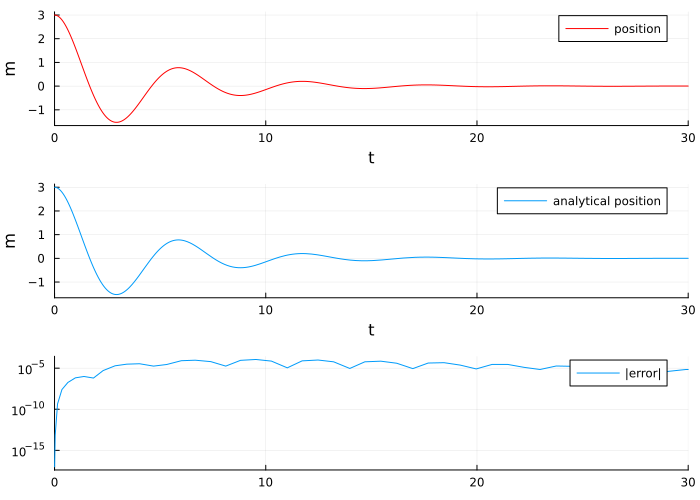

In [3]:
problem = PointMass.One_PointmassProblem(
    m=50.0, 
    γ=23.0, 
    k=60.0, 
    v0=0.0, 
    x0=3.0, 
    F=0.0
)

sol = PointMass.single_dof_numerical(problem, (0, 30))
sol_A = PointMass.single_dof_damped_noforce(problem)
sol_A_discrete = map(sol_A, sol.t)
err = sol_A_discrete - sol[2, :]

p1 = plot(sol, vars=2, label="position", ylabel="m", color=:red)
p2 = plot(sol_A, 0, 30, label="analytical position", xlabel="t", ylabel="m")
xlims!((0, 30))
p3 = plot(sol.t, abs.(err) .+ 1e-17, yaxis=:log, label="|error|", ylabel="")
xlims!((0, 30))

plot(p1, p2, p3, layout=(3, 1), size=(700, 500))

We can also apply a horizontal force to our point mass. Consider a force of 500 N:

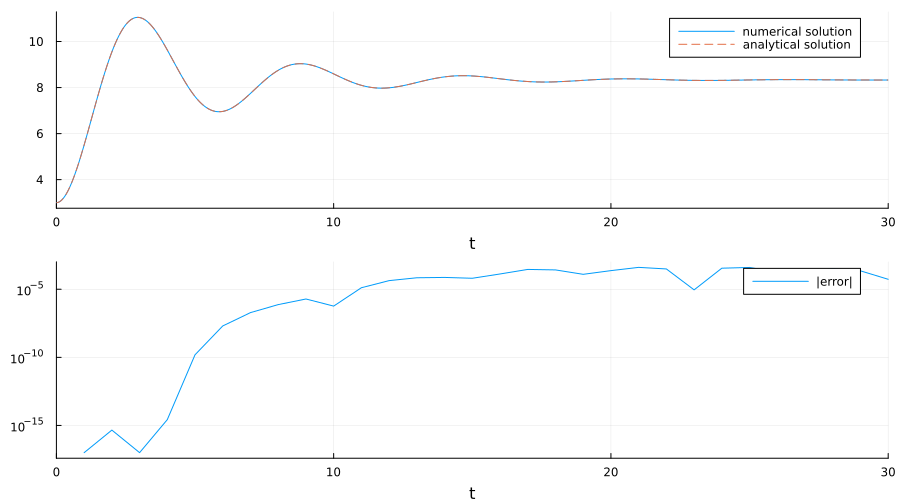

In [4]:
p = PointMass.One_PointmassProblem(
    m = 50,
    γ=23.0, 
    k=60.0, 
    v0=0.0, 
    x0=3.0, 
    F=500.0
)

sol_n = PointMass.single_dof_numerical(p, (0, 30))
sol_a = PointMass.single_dof_damped_force(p)

p1 = plot(sol_n, vars=2, label="numerical solution")
plot!(sol_a, 0, 30, line=:dash, label="analytical solution")

err = map(sol_a, sol_n.t) - sol_n[2, :]
p2 = plot(abs.(err) .+ 1e-17, yaxis=:log, xlabel="t", label="|error|", ylabel="")
xlims!((0, 30))

plot(p1, p2, layout=(2, 1), size=(900, 500))

### Simulating 2 point masses connected by springs

We aim to solve the equations:

$$m_1u_1'' = -(k_1+k_2)u_1 + k_2u_2$$
$$m_2u_2'' =  k_2u_1 - (k_2+k_3)u_2$$

Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)

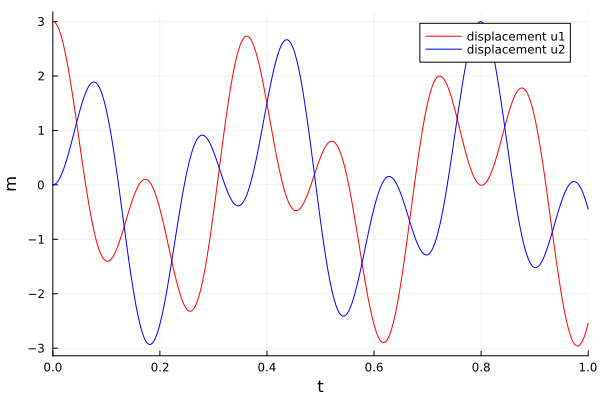

In [5]:
M = [40, 40]
K = [10000, 20000, 10000]
U0 = [3, 0]
tspan = (0, 1)

function two_degree_eq!(ddu, du, u, p, t)
    ddu[1] = -(K[1]+K[2])*u[1] / M[1] + K[2]*u[2] / M[1]
    ddu[2] = K[2]*u[1]/M[2] - (K[2] + K[3])*u[2] / M[2] 
end

function solve_eq(U0, tspan)
    prob = SecondOrderODEProblem(two_degree_eq!,[0,0], U0, tspan)                    
    sol = solve(prob)
    print(sol.alg) 
    sol
end

sol = solve_eq(U0, tspan)
plot(sol, vars=[3], label="displacement u1", xlabel="t", ylabel="m", color=:red)
plot!(sol, vars=[4], label="displacement u2", xlabel="t", ylabel="m", color=:blue)

[ Info: Saved animation to /Users/tudorandrei/repos/BusDoor_modeling2023/src/n_point_mass.gif


Plots.AnimatedGif("/Users/tudorandrei/repos/BusDoor_modeling2023/src/n_point_mass.gif")
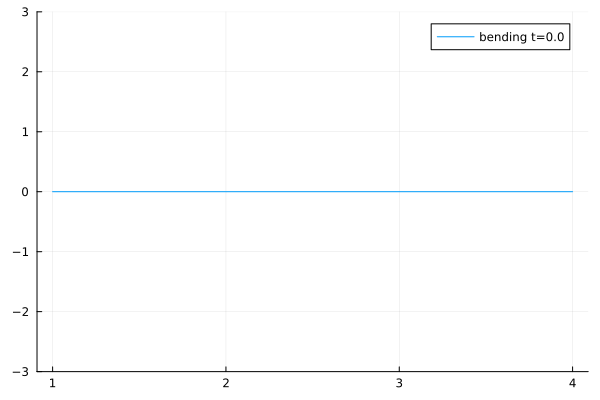

In [43]:
p = PointMass.N_PointmassProblem(
    m = [40.0, 40.0, 40.0, 40.0],
    γ = [23.0, 23.0, 23.0, 23, 23, 23],
    k = [10000.0, 10000.0, 10000, 10000, 10000.0],
    v0 = [0.0, 0.0, 0, 0],
    x0 = [0.0, 0.0, 0, 0],
    F = [0.0, 1000.0, 1000, 0]
)

n = size(p.m, 1)

sol = PointMass.n_dof_numerical(p, (0, 10))
anim = @animate for i ∈ 1:length(sol.t)
    plot(sol[n+1:end, i], label="bending t=$(sol.t[i])")
    ylims!(-3, 3)
end every 1
gif(anim, "n_point_mass.gif", fps=10)

### Point mass with collisions

![Alt text](../figures/spring-damper-collision.png)

To simulate this scenario we employ the same strategy as for the spring damper system in the beggining. We will use a callback function that is called by julia when our object reaches the coordinate of the walls.

We assume an elastic collision so we can get the new velocity from the formula:
$$v' = \frac{m - m_{wall}}{m + m_{wall}} \cdot v$$

Collision at time: 0.5555605987997361, x-coordinate: 4.999999999998218


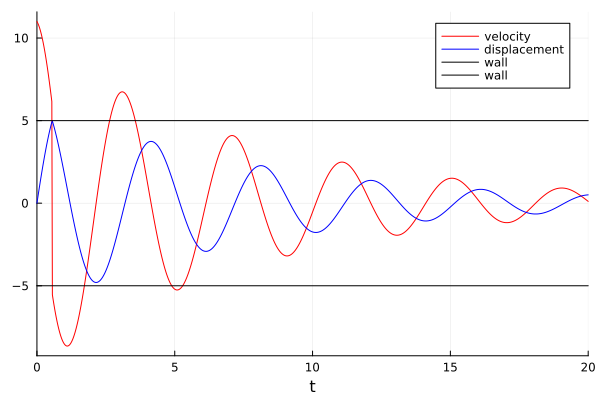

In [60]:

tspan = (0.0,20.0)      
Uᵣ = 5.0 # the wall is placed at 5 units to the right of the object
Uₗ = -5.0 # second wall is placed at 5 units to the left of the object
Mₗ = 1000 # mass of the wall

function spring_damper1D!(du, u, p, t)
    m, k, γ = p                                    
    du[1] = -1/m * (k*u[2] + γ*u[1]) 
    du[2] = u[1]                                                                 
end                                                                              

function condition(u, t, integrator) 
    (u[2]-Uₗ) * (u[2] - Uᵣ) # collision happens either at Ul or -Ul
end 

function affect!(integrator)
    coeff = (integrator.p[1] - Mₗ) / (integrator.p[1] + Mₗ) # assume wall has mass Ml, doesn't move and elastic collision occurs
    integrator.u[1] =  coeff * integrator.u[1]
    print("Collision at time: $(integrator.t), x-coordinate: $(integrator.u[2])\n")
end

function init_equation(v₀, x₀)                                                                   
    p = [40, 100, 10]                                                             
    prob = ODEProblem(spring_damper1D!,[v₀, x₀],tspan, p)                                                 
end

prob = init_equation(11.0, 0)
cb = ContinuousCallback(condition, affect!)
sol = solve(prob,callback=cb)

plot(sol, vars=[1], label="velocity", color = :red)
plot!(sol, vars=[2], label="displacement", color = :blue)

plot!(sol.t, repeat([Uᵣ], size(sol.t)[1]), label="wall", color = :black)
plot!(sol.t, repeat([Uₗ], size(sol.t)[1]), label="wall", color = :black)

# Beam Deflection


In [39]:
include("./Beam.jl")
import .Beam

### Static Equation

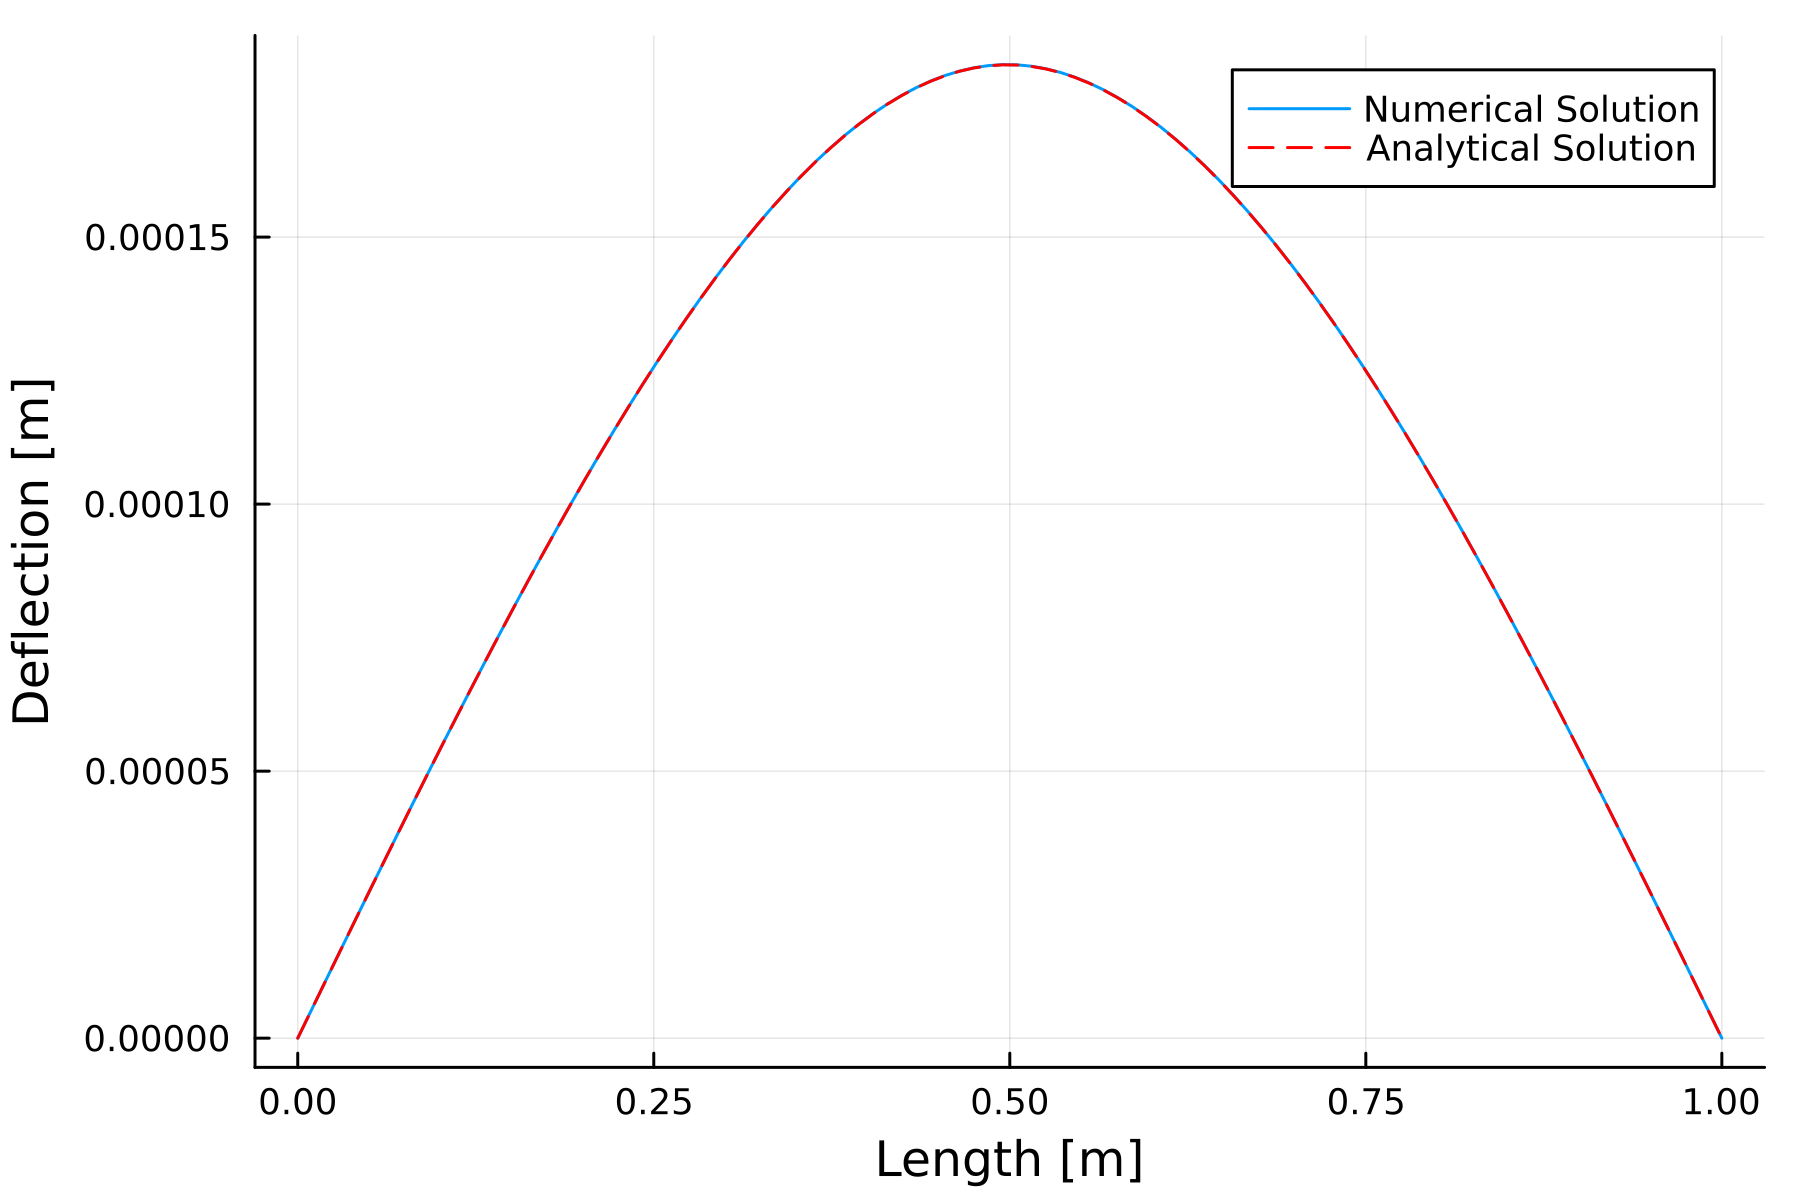

In [40]:
p = Beam.BeamProblem(
    N=100,
    L=1,
    μ=1,
    xp=50,
    EI=56000,
    f=Beam.point_load(490)
)

uA = Beam.static_eq_analytical(p, 490)
uN  = Beam.static_eq_numerical(p)
x = 0:p.h:p.L

plot(x, uN, label="Numerical Solution", xlabel="Length [m]", ylabel="Deflection [m]", show=true, dpi=300)
plot!(x, uA, label="Analytical Solution", linestyle=:dash, color=:red, show=true, dpi=300)


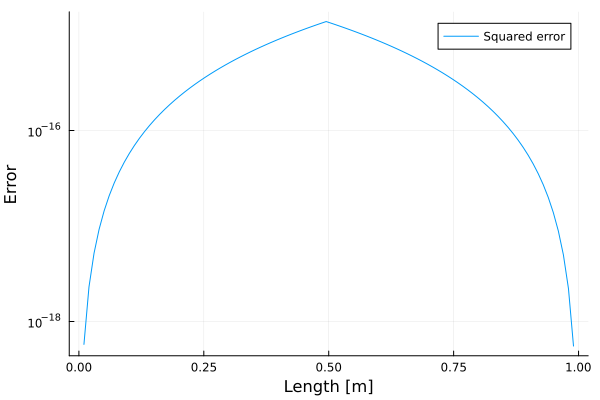

In [41]:
epsilon = 1e-40
plot(x[2:end-1], (uN[2:end-1].-uA[2:end-1]).^2, yaxis=:log, xlabel="Length [m]", ylabel="Error", label="Squared error")

### Dynamic Equation

In [42]:
p = Beam.BeamProblem(
    N=100,
    L=1,
    μ=1,
    xp=50,
    EI=56000,
    f=Beam.point_load(500)
)

sol = Beam.dynamic_eq_numerical(p, (0, 5.0))
Beam.animate_sol(sol)

LoadError: MethodError: no method matching strides(::ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}})

[0mClosest candidates are:
[0m  strides([91m::Union{Base.ReinterpretArray{T, N, S, A, IsReshaped} where {T, N, A<:Union{SubArray{T, N, A, I, true} where {T, N, A<:DenseArray, I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}}, DenseArray}, IsReshaped, S}, Base.ReshapedArray{T, N, A} where {T, N, A<:Union{Base.ReinterpretArray{T, N, S, A, IsReshaped} where {T, N, A<:Union{SubArray{T, N, A, I, true} where {T, N, A<:DenseArray, I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}}, DenseArray}, IsReshaped, S}, SubArray{T, N, A, I, true} where {T, N, A<:DenseArray, I<:Union{Tuple{Vararg{Real}}, Tuple{AbstractUnitRange, Vararg{Any}}}}, DenseArray}}, DenseArray}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mreinterpretarray.jl:173[24m[39m
[0m  strides([91m::SubArray[39m)
[0m[90m   @[39m [90mBase[39m [90m[4msubarray.jl:360[24m[39m
[0m  strides([91m::StaticArraysCore.SizedArray[39m)
[0m[90m   @[39m [36mStaticArrays[39m [90m~/.julia/packages/StaticArrays/cZ1ET/src/[39m[90m[4mabstractarray.jl:23[24m[39m
[0m  ...


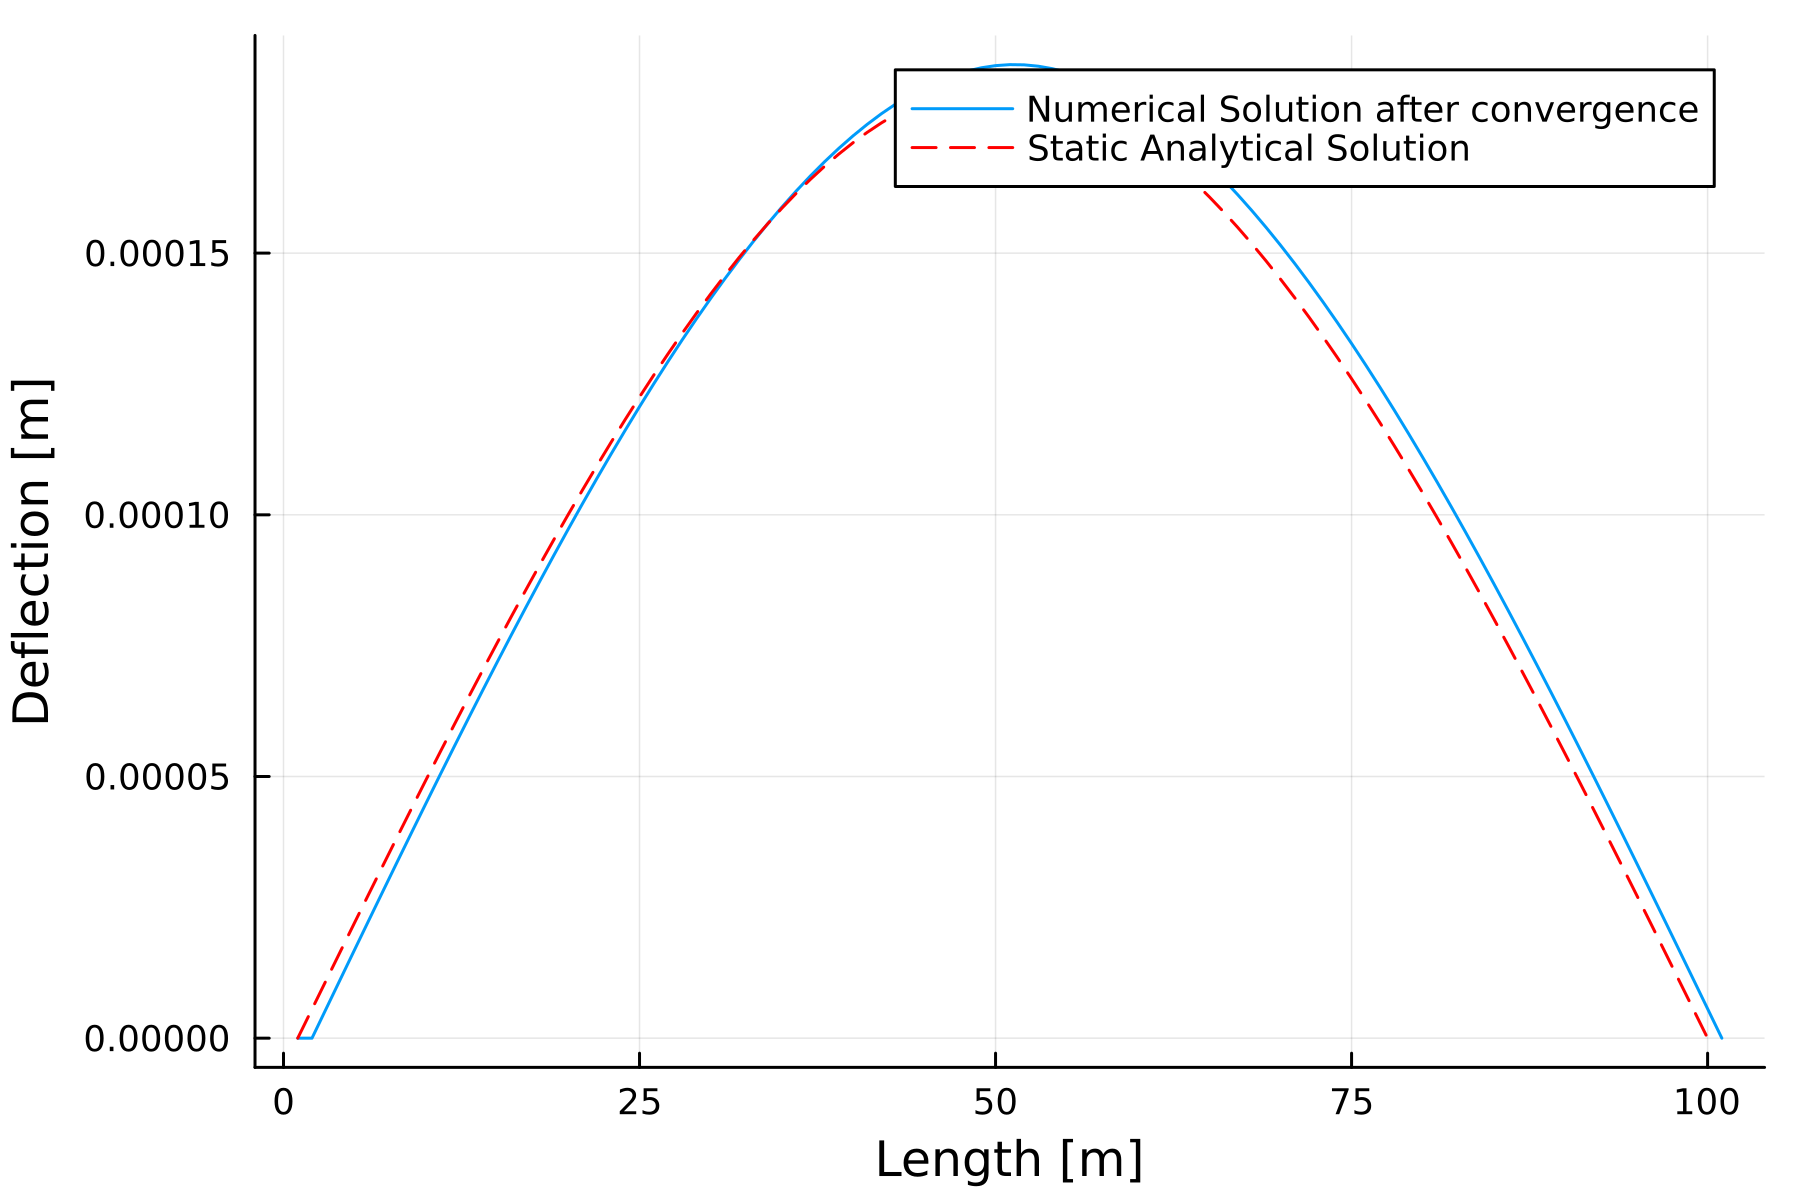

In [10]:
u_stable = (sol.u[end])[p.N:end]
plot(u_stable, label="Numerical Solution after convergence", xlabel="Length [m]", ylabel="Deflection [m]", show=true, dpi=300)
plot!(uA, label="Static Analytical Solution", linestyle=:dash, color=:red, show=true, dpi=300)

### Second approach
Another way to model this boundary condition is by changing the matrix we use to discretize the laplace operator. More specifically the first and last row of the matrix enforce the boundary conditions. For point $u_N$ we try to enforce the mass spring-damper equation:
$$m * u_n'' + \gamma * u_n' + k * u_n = 0$$ 
We will compute the derivatives using backward finite difference approximation of the first and second order like so:
$$ u_n'' = \frac{u_n - 2*u_{n-1} + u_{n-2}}{h^2} $$
$$ u_n' = \frac{u_n - u_{n-1}}{h} $$
We can plug these into the initial equation and turn it into a vector form equation:
$$
u_{n-2} * \frac{m}{h^2} + u_{n-1} * (\frac{-2*m}{h^2} - \frac{\gamma}{h}) + u_n * (\frac{m}{h^2} + \frac{\gamma}{h} + k) = 0
$$
$$
    \begin{bmatrix}
    0 & \dots & \dfrac{m}{h^2}, & \dfrac{-2*m}{h^2} - \dfrac{\gamma}{h}, & \dfrac{m}{h^2} + \dfrac{\gamma}{h} + k 
    \end{bmatrix}
    \cdot
    \begin{bmatrix} 
    u_1 \\
    \vdots \\
    u_{n-2} \\
    u_{n-1} \\
    u_n \\
    \end{bmatrix}
    = 0
$$

Pluggin this into the final row of the matrix should look like this:
$$
\begin{bmatrix}
1 & 0 & 0 & 0 & \dots & 0\\
-1 & 2 & -1 & 0 &\dots & 0 \\
\vdots & \vdots & \vdots & \vdots & & \vdots\\
0 & 0 & \dots & \dfrac{m}{h^2}, & \dfrac{-2*m}{h^2} - \dfrac{\gamma}{h}, & \dfrac{m}{h^2} + \dfrac{\gamma}{h} + k \\
\end{bmatrix}
\cdot
\begin{bmatrix} 
    u_1 \\
    u_2 \\
    \vdots \\
    u_{n-2} \\
    u_{n-1} \\
    u_n \\
\end{bmatrix}
= \begin{bmatrix}
0 \\
f_2 \\
\vdots\\
f_{n-2} \\
f_{n-1} \\
0
\end{bmatrix}
$$

┌ Info: Saved animation to /home/tandrei/Tudelft/ScientificProgramming/BusDoor_modeling2023/src/dynamic_beam.gif
└ @ Plots /home/tandrei/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/tandrei/Tudelft/ScientificProgramming/BusDoor_modeling2023/src/dynamic_beam.gif")
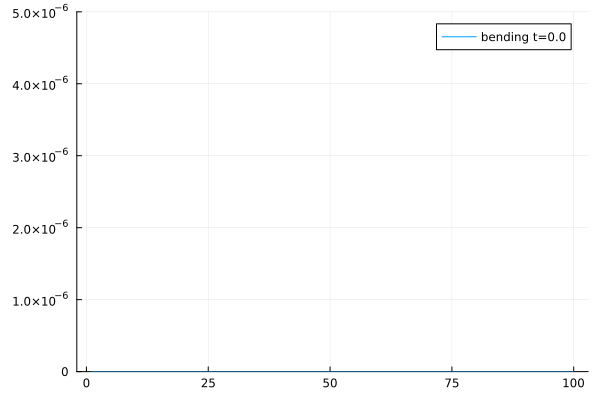

In [34]:
N = 100
p = Beam.BeamProblem(
    N=N,
    L=1,
    μ=1,
    xp=50,
    EI=56000,
    f=Beam.point_load(500)
)
# What is a good value for m in this case?
# The other constants are specific to the suspension being used
m = p.h * p.μ
k = 50
γ = 2*sqrt(k*m)

p.A2[N, N-2] = m / (p.h*p.h)
p.A2[N, N-1] = -2*m / (p.h*p.h) - (γ/p.h)
p.A2[N,   N] = 2*m / (p.h*p.h) + (γ/p.h) + k

sol = Beam.dynamic_eq_numerical(p, (0, 5.0))
Beam.animate_sol(sol)